<a href="https://colab.research.google.com/github/anmolmunnolli/Crop-Yield-Estimation-from-drone-footage-using-Deep-learning/blob/main/FYP_CropYieldEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import zipfile

# with zipfile.ZipFile('/content/drive/MyDrive/Data/global-wheat-detection.zip', 'r') as zip_ref:
#     zip_ref.extractall('FYPData')

In [14]:
import cv2
import math
import os

# Create a new directory to store the frames
if not os.path.exists('frames'):
    os.makedirs('frames')

# Open the video file
video = cv2.VideoCapture('/content/drive/MyDrive/Data/video.mp4')

# Get the total number of frames in the video
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Set the distance between frames
distance_between_frames = 1000000000000000000  # You can adjust this value to your needs

# Calculate the total distance traveled in the video
total_distance = total_frames * distance_between_frames

# Calculate the number of frames needed to cover the total distance
frames_per_distance = math.ceil(total_frames / total_distance)

# Initialize the frame number and distance traveled
frame_number = 0
distance_traveled = 0

# Iterate through each frame
while True:
    # Set the frame position
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = video.read()

    # Check if the frame was read successfully
    if not ret:
        break

    # Save the frame as an image in the "frames" directory
    cv2.imwrite(f'frames/frame_{frame_number}.jpg', frame)

    # Update the distance traveled
    distance_traveled += distance_between_frames

    # Calculate the next frame number
    if distance_traveled >= frames_per_distance:
        frame_number += 1
        distance_traveled -= frames_per_distance

# Release the video object
video.release()


In [13]:
!rm -rf frames

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_TRAIN = '/content/drive/MyDrive/Data/FYPData/train'
DIR_TEST = '/content/drive/MyDrive/Data/FYPData/test'


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Data/FYPData/train.csv')
train_df.shape

In [ ]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(float)
train_df['y'] = train_df['y'].astype(float)
train_df['w'] = train_df['w'].astype(float)
train_df['h'] = train_df['h'].astype(float)

In [ ]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [ ]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [ ]:
valid_df.shape, train_df.shape

In [ ]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [ ]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))

In [ ]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [ ]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [26]:
WEIGHTS_FILE = '/content/drive/MyDrive/fasterrcnn_resnet50_fpn.pth'


In [27]:
test_df = pd.read_csv('/content/drive/MyDrive/Data/FYPData/test.csv')
test_df.shape

(10, 2)

In [28]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [29]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])


In [30]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to pass

In [31]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

In [32]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [33]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [34]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

In [35]:
results[0:2]

[{'image_id': 'aac893a91',
  'PredictionString': '0.9849 74 2 95 158 0.9786 612 920 84 101 0.9735 740 773 78 115 0.9727 585 778 98 118 0.9687 698 398 113 176 0.9674 355 536 94 78 0.9626 304 0 73 65 0.9573 29 453 98 156 0.9526 458 861 83 87 0.9486 232 846 156 100 0.9472 821 710 103 203 0.9408 559 532 118 179 0.9264 441 697 101 85 0.9238 331 663 116 154 0.9138 554 76 125 171 0.9113 175 571 110 172 0.9075 265 121 103 105 0.9052 95 621 116 72 0.8980 826 630 82 125 0.8941 63 857 119 70 0.8480 389 333 87 83 0.8414 620 1 116 133 0.8413 168 6 72 137 0.7711 172 346 76 62 0.7607 247 94 69 69 0.7562 362 266 73 81 0.6777 826 908 119 111 0.6437 439 80 128 62 0.6138 586 597 92 117 0.5789 489 981 75 42 0.5647 563 538 85 113 0.5620 336 673 85 102 0.5297 450 171 137 76 0.5239 823 0 198 38 0.5043 815 976 102 48'},
 {'image_id': '51f1be19e',
  'PredictionString': '0.9578 280 477 134 112 0.9551 761 885 153 106 0.9529 12 2 109 75 0.9490 653 797 112 76 0.9468 802 769 109 93 0.9452 777 29 113 63 0.9441 181 9

In [36]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9849 74 2 95 158 0.9786 612 920 84 101 0.973...
1,51f1be19e,0.9578 280 477 134 112 0.9551 761 885 153 106 ...
2,f5a1f0358,0.9665 152 254 77 83 0.9588 543 278 107 105 0....
3,796707dd7,0.9496 712 843 96 85 0.9486 897 337 107 89 0.9...
4,51b3e36ab,0.9807 236 649 91 157 0.9805 0 913 87 110 0.97...


21  is the number of detected boxes
28  is the number of detected boxes
49 total detected boxes in the observed land


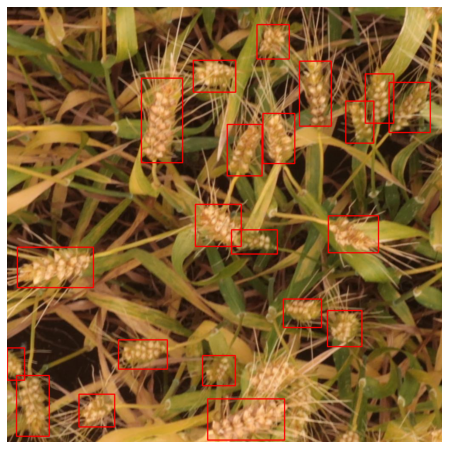

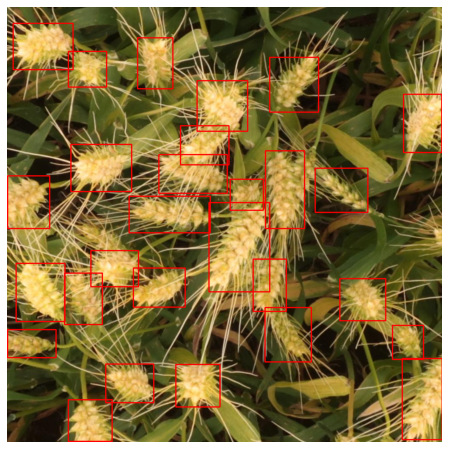

In [37]:
# sample = images[1].permute(1,2,0).cpu().numpy()
# boxes = outputs[1]['boxes'].data.cpu().numpy()
# scores = outputs[1]['scores'].data.cpu().numpy()

# boxes = boxes[scores >= detection_threshold].astype(np.int32)

total=0

for i, image in enumerate(images):
  boxes = outputs[i]['boxes'].data.cpu().numpy()
  scores = outputs[i]['scores'].data.cpu().numpy()
  sample = images[i].permute(1,2,0).cpu().numpy()      
  boxes = boxes[scores >= detection_threshold].astype(np.int32)



  fig, ax = plt.subplots(1, 1, figsize=(16, 8))

  for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
  print(len(boxes)," is the number of detected boxes")
  total+=len(boxes)
  ax.set_axis_off()
  ax.imshow(sample)
print(total,"total detected boxes in the observed land")



        

In [ ]:
total_boxes=49

In [ ]:
test_df.to_csv('output_testresults.csv', index=False)

Regression Analysis

In [ ]:
import numpy as np 
import pandas as pd 

In [ ]:
df_yield = pd.read_csv('/content/drive/MyDrive/Data/Mulika_harvest_2015.csv')
df_yield.shape

(96, 19)

In [ ]:
df_yield.head()

,Measured_24h_mean_O3,Watering_treatment,Pot_ID,presence_of_aphids,Ear_number_in_sampling_area,Ear_number_pplant,Ear_weight_in_sample_g,Dry_straw_weight_in_sample_g,Wet_grain_weight_in_sample_g,Dry_grain_weight_in_sample_g,100_grain_dry_weight_g,dry_grain_weight_per_ear_g,grain_number_per_ear,Ear_number_per_m2,Dry_straw_weight_pplant_g,Harvest_index,Dry_grain_weight_pplant_g,Yield_kg/m2,Yield_kg/ha
0,56.5,well-watered,84,without,40,2.857142857,87.41,45.79,69.08,59.87,4.9473,1.497,30.25251147,571.6,3.270714,0.566618,4.2762,0.855504,8555.03717
1,56.5,well-watered,48,without,34,2.833333333,77.07,46.56,60.96,54.11,4.9185,1.591,32.35593109,485.86,3.880000,0.537492,4.5090,0.773210,7732.10465
2,56.5,well-watered,5,without,43,2.388888889,85.99,58.13,66.88,63.00,4.2156,1.465,34.75220499,614.47,3.229444,0.520085,3.4998,0.900207,9002.07124
3,56.5,well-watered,55,without,32,3.2,73.07,41.97,57.05,51.06,4.7304,1.596,33.73155547,457.28,4.197000,0.548857,5.1060,0.729653,7296.53116
4,56.5,early-drought,57,without,26,2,54,35.73,41.12,36.41,5.1553,1.4,27.16047264,371.54,2.748462,0.504681,2.8004,0.520232,5202.31737


In [ ]:
df_yield.tail(10)

,Measured_24h_mean_O3,Watering_treatment,Pot_ID,presence_of_aphids,Ear_number_in_sampling_area,Ear_number_pplant,Ear_weight_in_sample_g,Dry_straw_weight_in_sample_g,Wet_grain_weight_in_sample_g,Dry_grain_weight_in_sample_g,100_grain_dry_weight_g,dry_grain_weight_per_ear_g,grain_number_per_ear,Ear_number_per_m2,Dry_straw_weight_pplant_g,Harvest_index,Dry_grain_weight_pplant_g,Yield_kg/m2,Yield_kg/ha
86,27.0,well-watered,29,with,37,2.642857143,91.48,57.07,70.08,67.21,4.6956,1.816,38.68233171,528.73,4.076429,0.540779,4.8004,0.960368,9603.68024
87,27.0,well-watered,70,with,36,2.25,70.28,46.96,53.65,51.79,4.6109,1.439,31.20076582,514.44,2.935000,0.524460,3.2369,0.740092,7400.91961
88,27.0,early-drought,51,with,31,2.583333333,74.77,38.78,57.10,53.14,4.7577,1.714,36.02831946,442.99,3.231667,0.578101,4.4281,0.759338,7593.37733
89,27.0,early-drought,62,with,17,2.428571429,49.44,26.78,37.62,35.60,4.6593,2.094,44.94401456,242.93,3.825714,0.570691,5.0856,0.508714,5087.13997
90,27.0,early-drought,66,with,40,2.666666667,96.03,51.52,74.51,70.53,4.5498,1.763,38.75434085,571.6,3.434667,0.577877,4.7020,1.007871,10078.70842
91,27.0,early-drought,21,with,not_recorded,not_recorded,not_recorded,39.04,42.89,40.88,4.4297,not_recorded,not_recorded,not_recorded,3.253333,0.511510,3.4066,0.584171,5841.70913
92,27.0,late-drought,1,with,38,2.235294118,80.42,50.64,60.78,56.30,4.8716,1.482,30.41343814,543.02,2.978824,0.526471,3.3119,0.804550,8045.49864
93,27.0,late-drought,87,with,39,2.4375,87.1,51.67,66.20,61.45,4.6546,1.576,33.85379999,557.31,3.229375,0.543247,3.8409,0.878186,8781.86234
94,27.0,late-drought,32,with,42,3.5,83.24,54.96,63.42,59.13,4.5094,1.408,31.22018134,600.18,4.580000,0.518273,4.9275,0.844959,8449.59126
95,27.0,late-drought,69,with,24,2.666666667,47.44,30.32,36.11,32.45,4.5546,1.352,29.69031309,342.96,3.368889,0.517002,3.6061,0.463776,4637.76234


In [ ]:
df_yield = df_yield.drop(['Pot_ID','Dry_straw_weight_in_sample_g','100_grain_dry_weight_g','Dry_straw_weight_pplant_g','Dry_grain_weight_pplant_g','Yield_kg/m2'], axis=1)
df_yield.head()

,Measured_24h_mean_O3,Watering_treatment,presence_of_aphids,Ear_number_in_sampling_area,Ear_number_pplant,Ear_weight_in_sample_g,Wet_grain_weight_in_sample_g,Dry_grain_weight_in_sample_g,dry_grain_weight_per_ear_g,grain_number_per_ear,Ear_number_per_m2,Harvest_index,Yield_kg/ha
0,56.5,well-watered,without,40,2.857142857,87.41,69.08,59.87,1.497,30.25251147,571.6,0.566618,8555.03717
1,56.5,well-watered,without,34,2.833333333,77.07,60.96,54.11,1.591,32.35593109,485.86,0.537492,7732.10465
2,56.5,well-watered,without,43,2.388888889,85.99,66.88,63.00,1.465,34.75220499,614.47,0.520085,9002.07124
3,56.5,well-watered,without,32,3.2,73.07,57.05,51.06,1.596,33.73155547,457.28,0.548857,7296.53116
4,56.5,early-drought,without,26,2,54,41.12,36.41,1.4,27.16047264,371.54,0.504681,5202.31737


In [ ]:
df_yield.describe()

,Measured_24h_mean_O3,Wet_grain_weight_in_sample_g,Dry_grain_weight_in_sample_g,Harvest_index,Yield_kg/ha
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,43.025000,53.630417,49.747396,0.528855,7108.925044
std,10.584606,12.726154,11.581639,0.040471,1654.959055
min,27.000000,26.350000,23.990000,0.369299,3427.542240
25%,35.325000,43.847500,40.207500,0.508352,5745.937550
50%,43.900000,53.830000,50.950000,0.528457,7281.069380
75%,51.500000,61.912500,56.480000,0.551199,8071.052733
max,56.500000,83.700000,76.080000,0.613085,10871.903450


In [ ]:
df_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Measured_24h_mean_O3          96 non-null     float64
 1   Watering_treatment            96 non-null     object 
 2   presence_of_aphids            96 non-null     object 
 3   Ear_number_in_sampling_area   96 non-null     object 
 4   Ear_number_pplant             96 non-null     object 
 5   Ear_weight_in_sample_g        96 non-null     object 
 6   Wet_grain_weight_in_sample_g  96 non-null     float64
 7   Dry_grain_weight_in_sample_g  96 non-null     float64
 8   dry_grain_weight_per_ear_g    96 non-null     object 
 9   grain_number_per_ear          96 non-null     object 
 10  Ear_number_per_m2             96 non-null     object 
 11  Harvest_index                 96 non-null     float64
 12  Yield_kg/ha                   96 non-null     float64
dtypes: floa

In [ ]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

<ipython-input-26-af8bc9ac82e2>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation_data, dtype=np.bool)


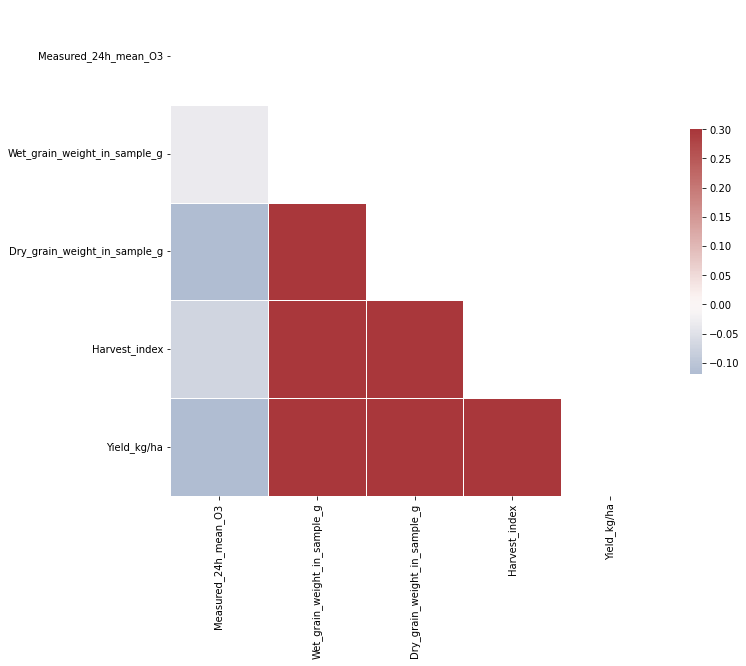

In [ ]:
correlation_data=df_yield.select_dtypes(include=[np.number]).corr()

mask = np.zeros_like(correlation_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.palette="vlag"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_data, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df_yield = df_yield[df_yield.Ear_number_in_sampling_area != 'not_recorded']

In [ ]:
df_yield["Ear_number_in_sampling_area"] = pd.to_numeric(df_yield["Ear_number_in_sampling_area"])
df_yield["Ear_number_pplant"] = pd.to_numeric(df_yield["Ear_number_pplant"])
#df_yield["Ear_weight_in_sample_g "] = pd.to_numeric(df_yield["Ear_weight_in_sample_g "])
df_yield["dry_grain_weight_per_ear_g"] = pd.to_numeric(df_yield["dry_grain_weight_per_ear_g"])
df_yield["grain_number_per_ear"] = pd.to_numeric(df_yield["grain_number_per_ear"])
df_yield["Ear_number_per_m2"] = pd.to_numeric(df_yield["Ear_number_per_m2"])


In [ ]:
yield_df_onehot = pd.get_dummies(df_yield, columns=['Watering_treatment',"presence_of_aphids"], prefix = ['Watering_treatment',"presence_of_aphids"])
features=yield_df_onehot.loc[:, yield_df_onehot.columns != 'Yield_kg/ha']
label=df_yield['Yield_kg/ha']
features.head()

,Measured_24h_mean_O3,Ear_number_in_sampling_area,Ear_number_pplant,Ear_weight_in_sample_g,Wet_grain_weight_in_sample_g,Dry_grain_weight_in_sample_g,dry_grain_weight_per_ear_g,grain_number_per_ear,Ear_number_per_m2,Harvest_index,Watering_treatment_early-drought,Watering_treatment_late-drought,Watering_treatment_well-watered,presence_of_aphids_with,presence_of_aphids_without
0,56.5,40,2.857143,87.41,69.08,59.87,1.497,30.252511,571.60,0.566618,0,0,1,0,1
1,56.5,34,2.833333,77.07,60.96,54.11,1.591,32.355931,485.86,0.537492,0,0,1,0,1
2,56.5,43,2.388889,85.99,66.88,63.00,1.465,34.752205,614.47,0.520085,0,0,1,0,1
3,56.5,32,3.200000,73.07,57.05,51.06,1.596,33.731555,457.28,0.548857,0,0,1,0,1
4,56.5,26,2.000000,54,41.12,36.41,1.400,27.160473,371.54,0.504681,1,0,0,0,1


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 95
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Measured_24h_mean_O3              95 non-null     float64
 1   Ear_number_in_sampling_area       95 non-null     int64  
 2   Ear_number_pplant                 95 non-null     float64
 3   Ear_weight_in_sample_g            95 non-null     object 
 4   Wet_grain_weight_in_sample_g      95 non-null     float64
 5   Dry_grain_weight_in_sample_g      95 non-null     float64
 6   dry_grain_weight_per_ear_g        95 non-null     float64
 7   grain_number_per_ear              95 non-null     float64
 8   Ear_number_per_m2                 95 non-null     float64
 9   Harvest_index                     95 non-null     float64
 10  Watering_treatment_early-drought  95 non-null     uint8  
 11  Watering_treatment_late-drought   95 non-null     uint8  
 12  Watering_t

In [ ]:
features.head()

,Measured_24h_mean_O3,Ear_number_in_sampling_area,Ear_number_pplant,Ear_weight_in_sample_g,Wet_grain_weight_in_sample_g,Dry_grain_weight_in_sample_g,dry_grain_weight_per_ear_g,grain_number_per_ear,Ear_number_per_m2,Harvest_index,Watering_treatment_early-drought,Watering_treatment_late-drought,Watering_treatment_well-watered,presence_of_aphids_with,presence_of_aphids_without
0,56.5,40,2.857143,87.41,69.08,59.87,1.497,30.252511,571.60,0.566618,0,0,1,0,1
1,56.5,34,2.833333,77.07,60.96,54.11,1.591,32.355931,485.86,0.537492,0,0,1,0,1
2,56.5,43,2.388889,85.99,66.88,63.00,1.465,34.752205,614.47,0.520085,0,0,1,0,1
3,56.5,32,3.200000,73.07,57.05,51.06,1.596,33.731555,457.28,0.548857,0,0,1,0,1
4,56.5,26,2.000000,54,41.12,36.41,1.400,27.160473,371.54,0.504681,1,0,0,0,1


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
features=scaler.fit_transform(features) 

In [ ]:
features

array([[1.        , 0.6969697 , 0.55858748, ..., 1.        , 0.        ,
        1.        ],
       [1.        , 0.51515152, 0.54681648, ..., 1.        , 0.        ,
        1.        ],
       [1.        , 0.78787879, 0.32709114, ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.66666667, 0.3511236 , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.75757576, 0.87640449, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.21212121, 0.46441948, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.2, random_state=42)

In [ ]:
from sklearn.metrics import r2_score
def compare_models(model):
    model_name = model.__class__.__name__
    fit=model.fit(train_data,train_labels)
    y_pred=fit.predict(test_data)
    r2=r2_score(test_labels,y_pred)
    return([model_name,r2])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

models = [
    GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=0),
     RandomForestRegressor(n_estimators=200, max_depth=3, random_state=0),
    svm.SVR(),
   DecisionTreeRegressor()
]

In [ ]:
model_train=list(map(compare_models,models)) 

In [ ]:
print(*model_train, sep = "\n")

['GradientBoostingRegressor', 0.9950895845293964]
['RandomForestRegressor', 0.9950113313246315]
['SVR', 0.004251063421332746]
['DecisionTreeRegressor', 0.9893670751920527]


In [ ]:
test_df=pd.DataFrame(test_data,columns=yield_df_onehot.loc[:, yield_df_onehot.columns != 'Yield_kg/ha'].columns) 


In [ ]:
test_df.head()

,Measured_24h_mean_O3,Ear_number_in_sampling_area,Ear_number_pplant,Ear_weight_in_sample_g,Wet_grain_weight_in_sample_g,Dry_grain_weight_in_sample_g,dry_grain_weight_per_ear_g,grain_number_per_ear,Ear_number_per_m2,Harvest_index,Watering_treatment_early-drought,Watering_treatment_late-drought,Watering_treatment_well-watered,presence_of_aphids_with,presence_of_aphids_without
0,0.111864,0.484848,0.629213,0.251884,0.310549,0.339988,0.315661,0.255045,0.484848,0.579287,0.0,1.0,0.0,0.0,1.0
1,0.962712,0.545455,0.719101,0.329527,0.375588,0.377424,0.301794,0.340345,0.545455,0.655297,0.0,1.0,0.0,1.0,0.0
2,0.413559,0.515152,0.266667,0.427837,0.478814,0.531580,0.524470,0.435548,0.515152,0.774970,0.0,0.0,1.0,1.0,0.0
3,0.413559,0.393939,1.000000,0.252341,0.261203,0.311384,0.377651,0.639873,0.393939,0.412081,0.0,0.0,1.0,1.0,0.0
4,1.000000,0.696970,0.558587,0.601393,0.745074,0.688808,0.505710,0.387847,0.696970,0.809392,0.0,0.0,1.0,0.0,1.0


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Measured_24h_mean_O3              19 non-null     float64
 1   Ear_number_in_sampling_area       19 non-null     float64
 2   Ear_number_pplant                 19 non-null     float64
 3   Ear_weight_in_sample_g            19 non-null     float64
 4   Wet_grain_weight_in_sample_g      19 non-null     float64
 5   Dry_grain_weight_in_sample_g      19 non-null     float64
 6   dry_grain_weight_per_ear_g        19 non-null     float64
 7   grain_number_per_ear              19 non-null     float64
 8   Ear_number_per_m2                 19 non-null     float64
 9   Harvest_index                     19 non-null     float64
 10  Watering_treatment_early-drought  19 non-null     float64
 11  Watering_treatment_late-drought   19 non-null     float64
 12  Watering_t

In [ ]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from math import sqrt

model = ensemble.GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=0)

model.fit(train_data, train_labels)


GradientBoostingRegressor(n_estimators=200, random_state=0)

In [ ]:
print(test_data)

[[0.11186441 0.48484848 0.62921348 0.25188399 0.31054926 0.33998848
  0.31566069 0.25504488 0.48484848 0.57928696 0.         1.
  0.         0.         1.        ]
 [0.96271186 0.54545455 0.71910112 0.32952729 0.37558849 0.37742369
  0.30179445 0.34034533 0.54545455 0.65529699 0.         1.
  0.         1.         0.        ]
 [0.41355932 0.51515152 0.26666667 0.42783741 0.4788143  0.53157996
  0.52446982 0.4355481  0.51515152 0.77497048 0.         0.
  1.         1.         0.        ]
 [0.41355932 0.39393939 1.         0.25234072 0.26120314 0.31138414
  0.3776509  0.63987303 0.39393939 0.41208078 0.         0.
  1.         1.         0.        ]
 [1.         0.6969697  0.55858748 0.60139301 0.74507411 0.68880783
  0.50570962 0.38784741 0.6969697  0.80939244 0.         0.
  1.         0.         1.        ]
 [0.73220339 0.90909091 0.80577849 1.         1.         0.94413515
  0.55464927 0.47238598 0.90909091 0.54843527 0.         0.
  1.         0.         1.        ]
 [0.78644068 0.6

In [ ]:

test_df["yield_predicted"]= model.predict(test_data)
test_df["yield_actual"]=pd.DataFrame(test_labels)["Yield_kg/ha"].tolist()
print(test_df["yield_actual"])
print(test_df["yield_predicted"])

0      5958.74423
1      6238.19947
2      7385.25777
3      5746.36625
4      8555.03717
5     10456.39312
6      9895.33914
7      8648.02220
8      7439.44545
9      6937.09479
10     7358.79269
11     7512.33874
12     7975.94921
13     7724.60240
14     6506.99437
15     5202.31737
16     3838.83702
17     5465.72494
18     9257.97656
Name: yield_actual, dtype: float64
0      5977.108318
1      6401.833968
2      7383.913130
3      5740.826040
4      8618.992750
5     10774.574056
6     10026.644746
7      8617.909567
8      7401.544454
9      6795.969378
10     7342.266568
11     7563.542043
12     7974.205584
13     7730.755521
14     6547.220225
15     5268.837311
16     3633.344552
17     5474.237236
18     9414.635593
Name: yield_predicted, dtype: float64


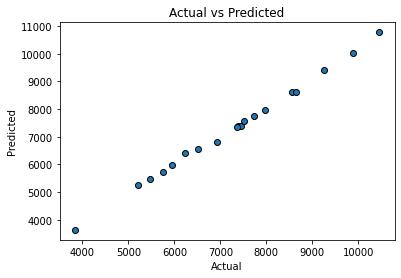

In [ ]:
fig, ax = plt.subplots() 

ax.scatter(test_df["yield_actual"], test_df["yield_predicted"],edgecolors=(0, 0, 0))

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()

In [ ]:
varimp= {'imp':model.feature_importances_,'names':yield_df_onehot.columns[yield_df_onehot.columns!="Yield_kg/ha"]}

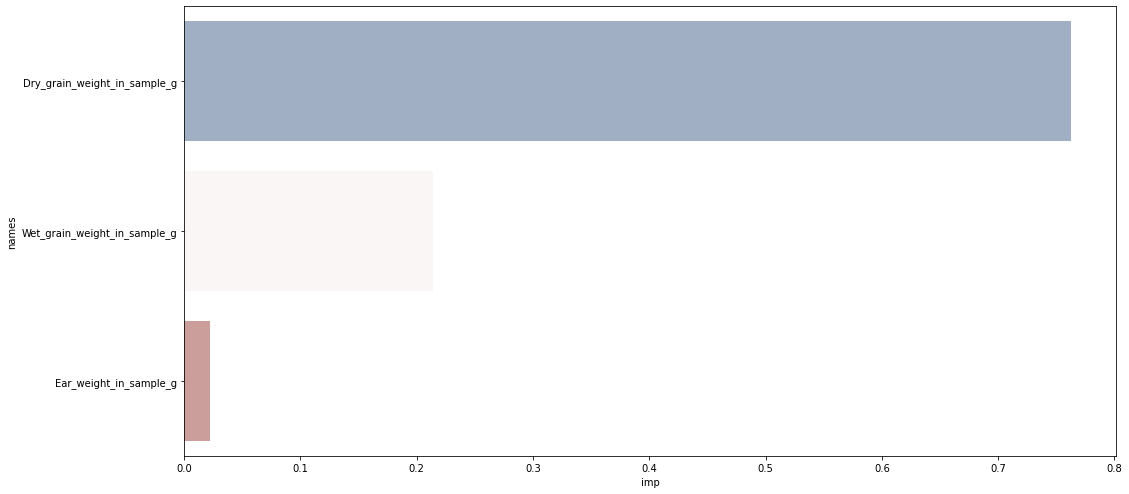

In [ ]:
#7 most important factors that affect crops 
a4_dims = (16.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
df=pd.DataFrame.from_dict(varimp)
df.sort_values(ascending=False,by=["imp"],inplace=True)
df=df.dropna()
df=df.nlargest(3, 'imp')
sns.barplot(x="imp",y="names",palette="vlag",data=df,orient="h",ax=ax);

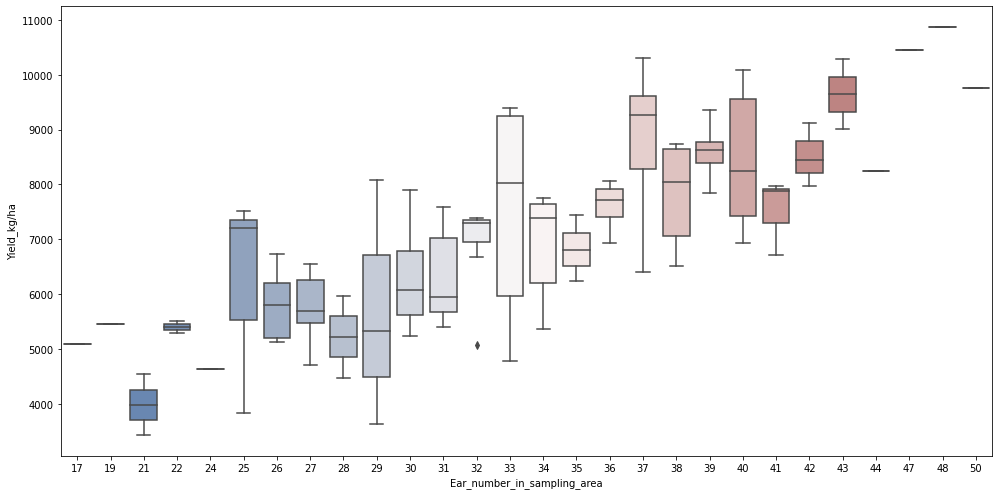

In [ ]:
#Boxplot that shows yield for each item 
a4_dims = (16.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(x="Ear_number_in_sampling_area",y="Yield_kg/ha",palette="vlag",data=df_yield,ax=ax);

In [ ]:
yieldprediction_df = pd.read_csv('/content/drive/MyDrive/Data/fromOD.csv')
yieldprediction_df.shape

(1, 15)

In [ ]:
yieldprediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Measured_24h_mean_O3              1 non-null      float64
 1   Ear_number_in_sampling_area       1 non-null      int64  
 2   Ear_number_pplant                 1 non-null      float64
 3   Ear_weight_in_sample_g            1 non-null      float64
 4   Wet_grain_weight_in_sample_g      1 non-null      float64
 5   Dry_grain_weight_in_sample_g      1 non-null      float64
 6   dry_grain_weight_per_ear_g        1 non-null      float64
 7   grain_number_per_ear              1 non-null      float64
 8   Ear_number_per_m2                 1 non-null      float64
 9   Harvest_index                     1 non-null      float64
 10  Watering_treatment_early-drought  1 non-null      int64  
 11  Watering_treatment_late-drought   1 non-null      int64  
 12  Watering_tre

In [ ]:
new_row = np.array(yieldprediction_df).reshape(1, -1)
print(new_row)

[[5.0500000e+01 4.9000000e+01 3.1000000e+00 7.6990000e+01 6.0690000e+01
  5.7890000e+01 1.4250000e+00 3.3867986e+01 6.0000000e+02 5.2000000e-01
  0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 1.0000000e+00]]


In [ ]:
predicted_target = model.predict(new_row)
print(predicted_target)

[10869.20380908]
